###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1723,Romania,2007,5.394,9.901,0.736,64.86,0.686,-0.194,0.949,0.575,0.277
2040,Taiwan Province of China,2023,6.655,NaN,0.872,NaN,0.795,NaN,0.641,0.748,0.111
401,Chile,2019,5.942,10.119,0.869,70.00,0.659,-0.110,0.860,0.741,0.337
203,Benin,2019,4.976,8.057,0.442,55.50,0.770,-0.018,0.698,0.638,0.441
896,India,2015,4.342,8.596,0.610,59.10,0.777,-0.010,0.776,0.657,0.322


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_55380\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


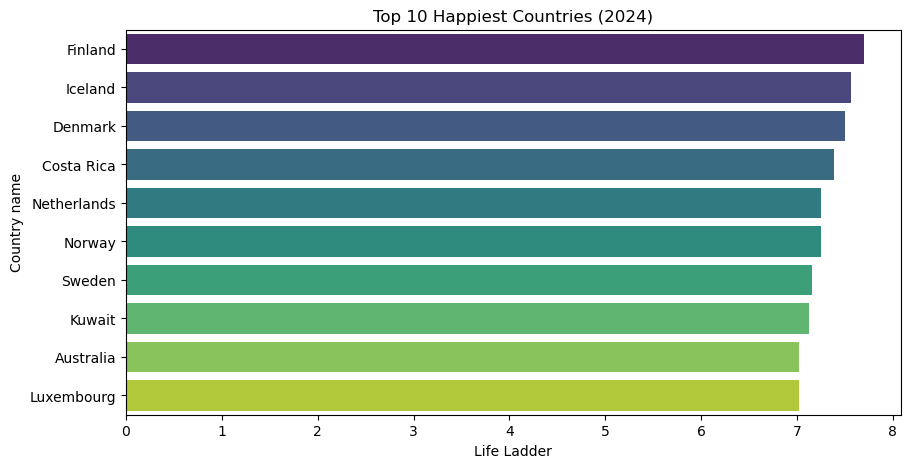

C:\Users\Sohin\AppData\Local\Temp\ipykernel_55380\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


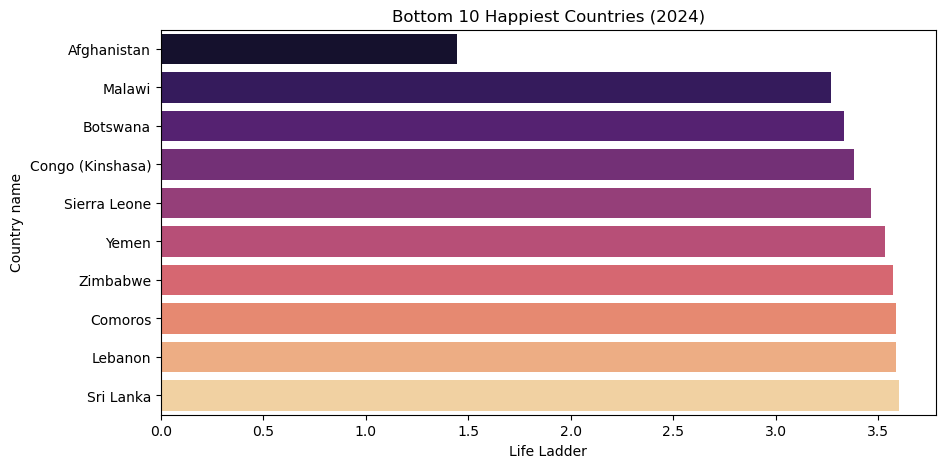

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


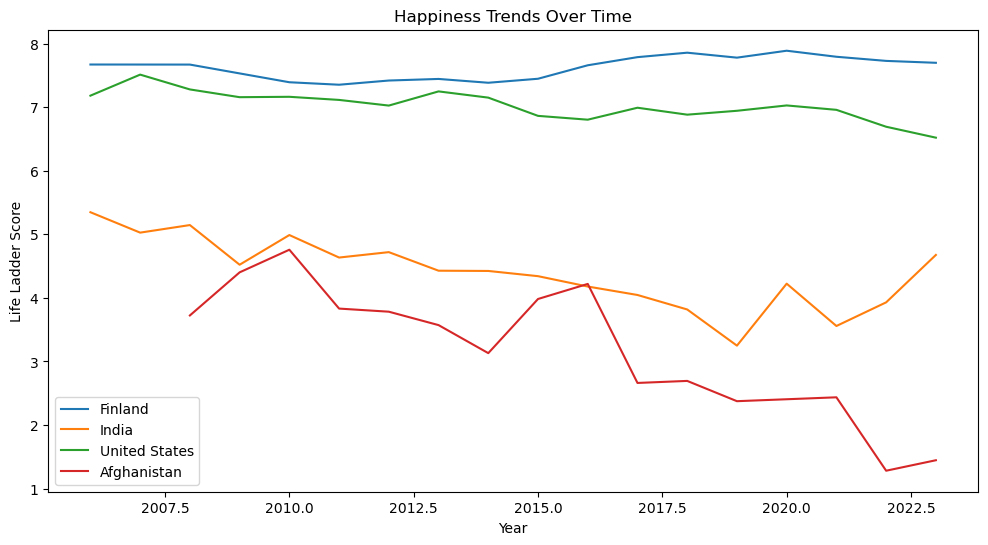

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


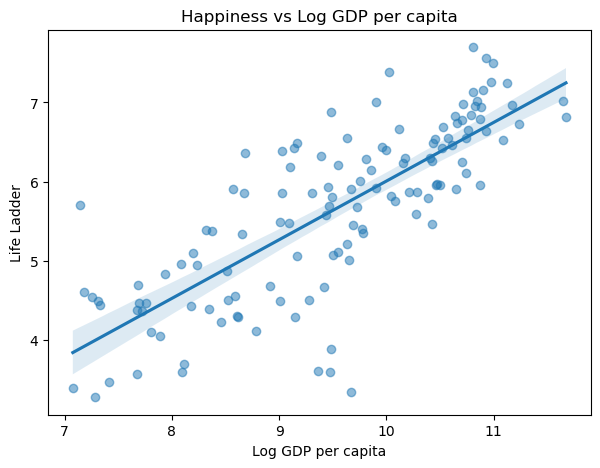

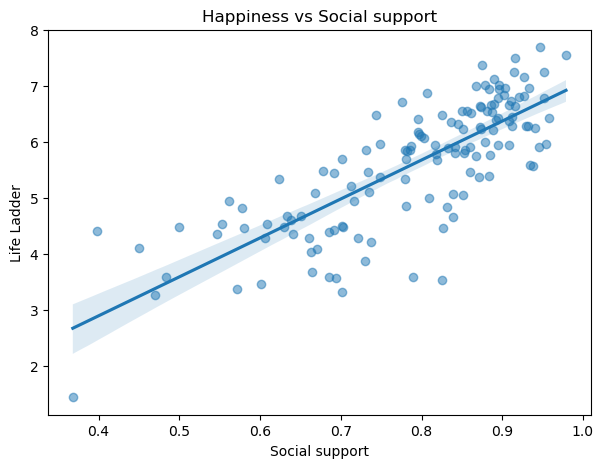

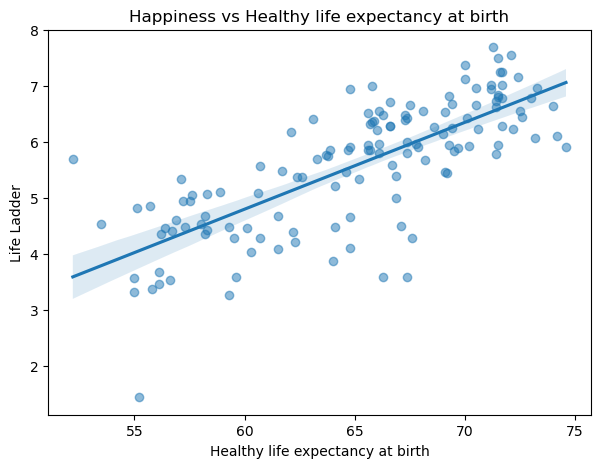

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


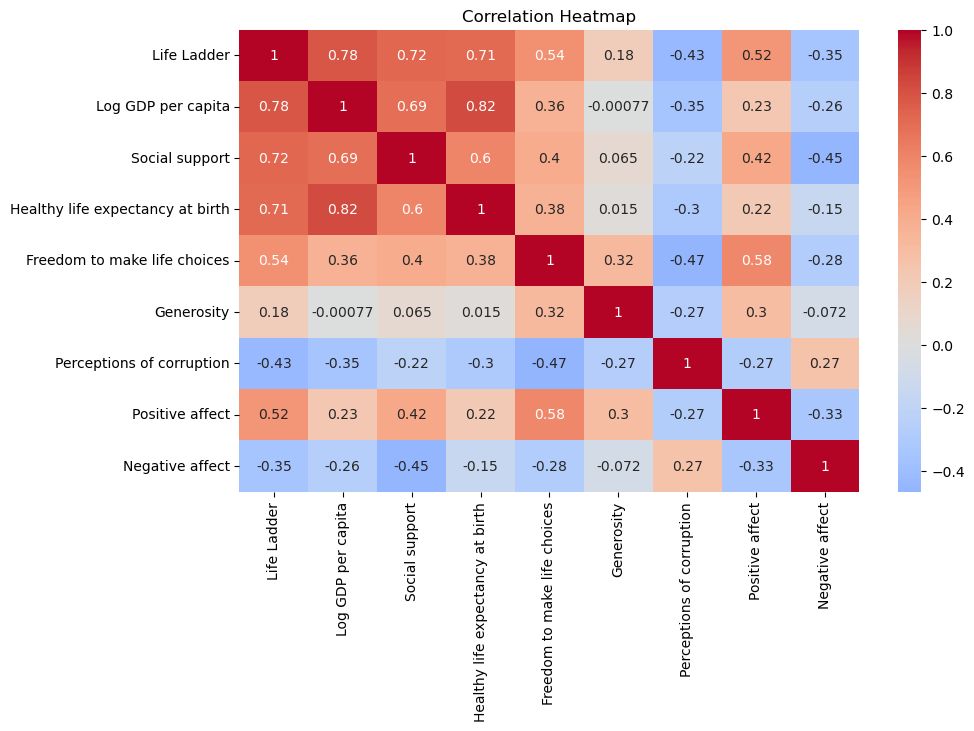

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


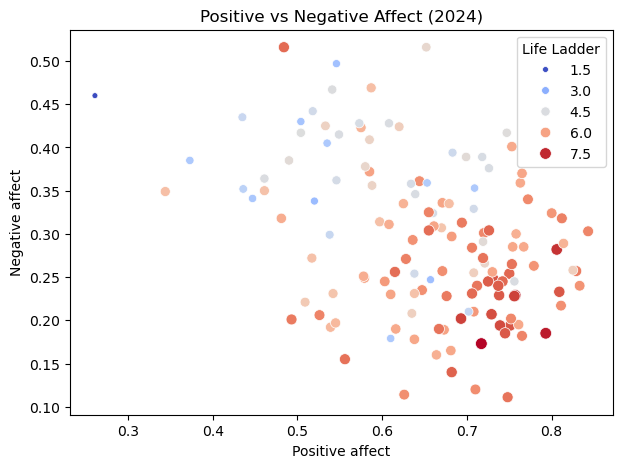

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [26]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

In [27]:
# scaler = StandardScaler()
# scaler.fit(features_train)
# features_train = scaler.transform(features_train)
# features_test = scaler.transform(features_test)

In [28]:
# # For neural networks specifically, standardizing the target is often also a good idea--we can inverse transform to compare to other models
# target_scaler = StandardScaler()
# target_scaler.fit(target_train.values.reshape(-1,1))
# target_train_scaled = target_scaler.transform(target_train.values.reshape(-1,1)).flatten()
# target_test_scaled = target_scaler.transform(target_test.values.reshape(-1,1)).flatten()

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [29]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [ ]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 08:33:47,613] A new study created in memory with name: no-name-2c88fdc5-ab5f-4d91-a3d8-89b365c29c8a
[I 2025-09-30 08:33:47,673] Trial 0 finished with value: 0.43618797850608826 and parameters: {'n_estimators': 180, 'max_depth': 3}. Best is trial 0 with value: 0.43618797850608826.
[I 2025-09-30 08:33:47,850] Trial 1 finished with value: 0.34968870609525654 and parameters: {'n_estimators': 60, 'max_depth': 9}. Best is trial 1 with value: 0.34968870609525654.
[I 2025-09-30 08:33:48,125] Trial 2 finished with value: 0.34798446585640075 and parameters: {'n_estimators': 70, 'max_depth': 10}. Best is trial 2 with value: 0.34798446585640075.
[I 2025-09-30 08:33:48,184] Trial 3 finished with value: 0.3991149482235076 and parameters: {'n_estimators': 190, 'max_depth': 4}. Best is trial 2 with value: 0.34798446585640075.
[I 2025-09-30 08:33:49,184] Trial 4 finished with value: 0.33815249847987344 and parameters: {'n_estimators': 160, 'max_depth': 12}. Best is trial 4 with value: 0.3

In [ ]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 160, 'max_depth': 15}
At trial:  26
Mean absolute error:  0.3313335351906126

Hyperparameter importances:


{'max_depth': 0.9596037094358948, 'n_estimators': 0.04039629056410521}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rtf = RandomForestRegressor()
rtf.fit(features_train, target_train)
rtf_pred = rtf.predict(features_test)
rtf_mae = mean_absolute_error(target_test, rtf_pred)
rtf_mae


0.33445813492063486

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr= DecisionTreeRegressor()
dtr.fit(features_train, target_train)
dtr_pred = rtf.predict(features_test)
dtr_mae = mean_absolute_error(target_test, dtr_pred)
dtr_mae


0.33445813492063486

In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_pred)
lgbm_mae

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.32155635237480695

In [ ]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
cbr.fit(features_train, target_train)
cbr_pred = cbr.predict(features_test)
cbr_mae = mean_absolute_error(target_test, cbr_pred)
cbr_mae

Learning rate set to 0.044626
0:	learn: 1.0948076	total: 143ms	remaining: 2m 22s
1:	learn: 1.0603695	total: 144ms	remaining: 1m 11s
2:	learn: 1.0276068	total: 145ms	remaining: 48.3s
3:	learn: 0.9969302	total: 146ms	remaining: 36.5s
4:	learn: 0.9677158	total: 148ms	remaining: 29.4s
5:	learn: 0.9407344	total: 149ms	remaining: 24.7s
6:	learn: 0.9142003	total: 151ms	remaining: 21.4s
7:	learn: 0.8899628	total: 152ms	remaining: 18.8s
8:	learn: 0.8662062	total: 153ms	remaining: 16.9s
9:	learn: 0.8423363	total: 155ms	remaining: 15.3s
10:	learn: 0.8198180	total: 156ms	remaining: 14s
11:	learn: 0.8005310	total: 157ms	remaining: 12.9s
12:	learn: 0.7803021	total: 158ms	remaining: 12s
13:	learn: 0.7611693	total: 159ms	remaining: 11.2s
14:	learn: 0.7430790	total: 160ms	remaining: 10.5s
15:	learn: 0.7261684	total: 162ms	remaining: 9.93s
16:	learn: 0.7108020	total: 163ms	remaining: 9.41s
17:	learn: 0.6956628	total: 164ms	remaining: 8.94s
18:	learn: 0.6811953	total: 165ms	remaining: 8.53s
19:	learn: 0.

0.3189764501039697

In [ ]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 08:26:55,218] A new study created in memory with name: no-name-e8c7e1bf-e62d-4517-a804-8673378bd39b
[I 2025-09-30 08:26:55,348] Trial 0 finished with value: 0.34189074981605266 and parameters: {'n_estimators': 90, 'max_depth': 5}. Best is trial 0 with value: 0.34189074981605266.


Learning rate set to 0.316077
0:	learn: 0.8897811	total: 1.25ms	remaining: 112ms
1:	learn: 0.7445705	total: 2.14ms	remaining: 94.1ms
2:	learn: 0.6420283	total: 2.98ms	remaining: 86.4ms
3:	learn: 0.5682397	total: 3.73ms	remaining: 80.3ms
4:	learn: 0.5298956	total: 4.52ms	remaining: 76.8ms
5:	learn: 0.5049664	total: 5.27ms	remaining: 73.8ms
6:	learn: 0.4888127	total: 6.03ms	remaining: 71.5ms
7:	learn: 0.4775533	total: 6.82ms	remaining: 70ms
8:	learn: 0.4686444	total: 7.59ms	remaining: 68.3ms
9:	learn: 0.4632805	total: 8.33ms	remaining: 66.6ms
10:	learn: 0.4575991	total: 9.16ms	remaining: 65.8ms
11:	learn: 0.4537965	total: 9.88ms	remaining: 64.2ms
12:	learn: 0.4507573	total: 10.5ms	remaining: 62.4ms
13:	learn: 0.4467053	total: 11.3ms	remaining: 61.5ms
14:	learn: 0.4431587	total: 12.2ms	remaining: 60.8ms
15:	learn: 0.4397849	total: 12.9ms	remaining: 59.7ms
16:	learn: 0.4346913	total: 13.8ms	remaining: 59.1ms
17:	learn: 0.4317641	total: 14.6ms	remaining: 58.5ms
18:	learn: 0.4301618	total: 1

[I 2025-09-30 08:26:55,463] Trial 1 finished with value: 0.34901051783304154 and parameters: {'n_estimators': 80, 'max_depth': 5}. Best is trial 0 with value: 0.34189074981605266.
[I 2025-09-30 08:26:55,520] Trial 2 finished with value: 0.3755871763860329 and parameters: {'n_estimators': 10, 'max_depth': 7}. Best is trial 0 with value: 0.34189074981605266.


Learning rate set to 0.5
0:	learn: 0.7431459	total: 2.01ms	remaining: 18.1ms
1:	learn: 0.5757041	total: 3.59ms	remaining: 14.4ms
2:	learn: 0.5037166	total: 5.17ms	remaining: 12.1ms
3:	learn: 0.4735817	total: 6.71ms	remaining: 10.1ms
4:	learn: 0.4540923	total: 8.24ms	remaining: 8.24ms
5:	learn: 0.4418239	total: 9.85ms	remaining: 6.57ms
6:	learn: 0.4317643	total: 11.5ms	remaining: 4.93ms
7:	learn: 0.4210117	total: 13.4ms	remaining: 3.34ms
8:	learn: 0.4133075	total: 15.1ms	remaining: 1.68ms
9:	learn: 0.4044129	total: 16.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7885794	total: 71.4ms	remaining: 642ms
1:	learn: 0.5984781	total: 143ms	remaining: 571ms
2:	learn: 0.4845658	total: 214ms	remaining: 499ms
3:	learn: 0.4154877	total: 285ms	remaining: 428ms
4:	learn: 0.3783091	total: 357ms	remaining: 357ms
5:	learn: 0.3472244	total: 426ms	remaining: 284ms
6:	learn: 0.3227907	total: 497ms	remaining: 213ms


[I 2025-09-30 08:26:56,279] Trial 3 finished with value: 0.3855254666132259 and parameters: {'n_estimators': 10, 'max_depth': 13}. Best is trial 0 with value: 0.34189074981605266.


7:	learn: 0.3027742	total: 569ms	remaining: 142ms
8:	learn: 0.2833387	total: 638ms	remaining: 70.9ms
9:	learn: 0.2683051	total: 713ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8289580	total: 584us	remaining: 5.26ms
1:	learn: 0.6596427	total: 1.12ms	remaining: 4.48ms
2:	learn: 0.5898128	total: 1.53ms	remaining: 3.56ms
3:	learn: 0.5511462	total: 1.87ms	remaining: 2.81ms
4:	learn: 0.5342889	total: 2.23ms	remaining: 2.23ms
5:	learn: 0.5259741	total: 2.6ms	remaining: 1.73ms
6:	learn: 0.5192214	total: 2.95ms	remaining: 1.26ms
7:	learn: 0.5124882	total: 3.29ms	remaining: 823us
8:	learn: 0.5092877	total: 3.63ms	remaining: 403us
9:	learn: 0.5058039	total: 4.02ms	remaining: 0us


[I 2025-09-30 08:26:56,322] Trial 4 finished with value: 0.4123438442191342 and parameters: {'n_estimators': 10, 'max_depth': 2}. Best is trial 0 with value: 0.34189074981605266.
[I 2025-09-30 08:26:56,372] Trial 5 pruned. 


Learning rate set to 0.5
0:	learn: 0.7677481	total: 1.37ms	remaining: 12.3ms
1:	learn: 0.6001577	total: 2.4ms	remaining: 9.6ms
2:	learn: 0.5214687	total: 3.24ms	remaining: 7.56ms
3:	learn: 0.4882507	total: 4.27ms	remaining: 6.41ms
4:	learn: 0.4741013	total: 5.16ms	remaining: 5.16ms
5:	learn: 0.4640610	total: 5.98ms	remaining: 3.99ms
6:	learn: 0.4583270	total: 6.73ms	remaining: 2.88ms
7:	learn: 0.4522034	total: 7.44ms	remaining: 1.86ms
8:	learn: 0.4463206	total: 8.24ms	remaining: 915us
9:	learn: 0.4429017	total: 9.04ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9894452	total: 36.8ms	remaining: 5.84s
1:	learn: 0.8600471	total: 73.4ms	remaining: 5.8s
2:	learn: 0.7607702	total: 109ms	remaining: 5.69s
3:	learn: 0.6796998	total: 145ms	remaining: 5.67s
4:	learn: 0.6120606	total: 184ms	remaining: 5.7s
5:	learn: 0.5644477	total: 220ms	remaining: 5.65s
6:	learn: 0.5210812	total: 256ms	remaining: 5.6s
7:	learn: 0.4856422	total: 291ms	remaining: 5.54s
8:	learn: 0.4550644	total: 329ms	

[I 2025-09-30 08:27:02,318] Trial 6 finished with value: 0.3329259759472087 and parameters: {'n_estimators': 160, 'max_depth': 12}. Best is trial 6 with value: 0.3329259759472087.


157:	learn: 0.0475701	total: 5.74s	remaining: 72.7ms
158:	learn: 0.0471812	total: 5.78s	remaining: 36.4ms
159:	learn: 0.0466267	total: 5.82s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7885794	total: 71ms	remaining: 2.77s
1:	learn: 0.5984781	total: 143ms	remaining: 2.71s
2:	learn: 0.4845658	total: 215ms	remaining: 2.65s
3:	learn: 0.4154877	total: 287ms	remaining: 2.58s
4:	learn: 0.3783091	total: 362ms	remaining: 2.53s
5:	learn: 0.3472244	total: 433ms	remaining: 2.46s
6:	learn: 0.3227907	total: 504ms	remaining: 2.37s
7:	learn: 0.3027742	total: 575ms	remaining: 2.3s
8:	learn: 0.2833387	total: 647ms	remaining: 2.23s
9:	learn: 0.2683051	total: 717ms	remaining: 2.15s
10:	learn: 0.2568579	total: 789ms	remaining: 2.08s
11:	learn: 0.2452330	total: 860ms	remaining: 2s
12:	learn: 0.2347369	total: 932ms	remaining: 1.93s
13:	learn: 0.2220674	total: 1s	remaining: 1.86s
14:	learn: 0.2109944	total: 1.08s	remaining: 1.79s
15:	learn: 0.2012227	total: 1.15s	remaining: 1.72s
16:	learn: 0.1934117	

[I 2025-09-30 08:27:05,227] Trial 7 pruned. 


39:	learn: 0.0787578	total: 2.83s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0059718	total: 748us	remaining: 149ms
1:	learn: 0.9040017	total: 1.35ms	remaining: 134ms
2:	learn: 0.8266170	total: 1.82ms	remaining: 119ms
3:	learn: 0.7651483	total: 2.28ms	remaining: 112ms
4:	learn: 0.7102197	total: 2.79ms	remaining: 109ms
5:	learn: 0.6670900	total: 3.29ms	remaining: 106ms
6:	learn: 0.6309063	total: 3.81ms	remaining: 105ms
7:	learn: 0.6036418	total: 4.45ms	remaining: 107ms
8:	learn: 0.5783399	total: 4.98ms	remaining: 106ms
9:	learn: 0.5592631	total: 5.57ms	remaining: 106ms
10:	learn: 0.5460815	total: 6.05ms	remaining: 104ms
11:	learn: 0.5345332	total: 6.59ms	remaining: 103ms
12:	learn: 0.5215916	total: 7.13ms	remaining: 103ms
13:	learn: 0.5128362	total: 7.58ms	remaining: 101ms
14:	learn: 0.5059521	total: 8.01ms	remaining: 98.7ms
15:	learn: 0.4988554	total: 8.51ms	remaining: 97.9ms
16:	learn: 0.4941369	total: 8.97ms	remaining: 96.6ms
17:	learn: 0.4902118	total: 9.42ms	remaining:

[I 2025-09-30 08:27:05,395] Trial 8 finished with value: 0.34247888299601026 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 6 with value: 0.3329259759472087.
[I 2025-09-30 08:27:05,471] Trial 9 pruned. 


Learning rate set to 0.439496
0:	learn: 0.8199586	total: 694us	remaining: 41ms
1:	learn: 0.6508926	total: 1.24ms	remaining: 35.8ms
2:	learn: 0.5855279	total: 1.73ms	remaining: 32.9ms
3:	learn: 0.5480587	total: 2.2ms	remaining: 30.8ms
4:	learn: 0.5236595	total: 2.68ms	remaining: 29.5ms
5:	learn: 0.5082638	total: 3.19ms	remaining: 28.7ms
6:	learn: 0.4992370	total: 3.67ms	remaining: 27.8ms
7:	learn: 0.4934083	total: 4.1ms	remaining: 26.7ms
8:	learn: 0.4884094	total: 4.86ms	remaining: 27.5ms
9:	learn: 0.4833435	total: 5.41ms	remaining: 27.1ms
10:	learn: 0.4805307	total: 5.95ms	remaining: 26.5ms
11:	learn: 0.4776274	total: 6.59ms	remaining: 26.4ms
12:	learn: 0.4742714	total: 7.06ms	remaining: 25.5ms
13:	learn: 0.4724827	total: 7.63ms	remaining: 25.1ms
14:	learn: 0.4699016	total: 8.17ms	remaining: 24.5ms
15:	learn: 0.4671954	total: 8.88ms	remaining: 24.4ms
16:	learn: 0.4644390	total: 9.37ms	remaining: 23.7ms
17:	learn: 0.4625055	total: 9.88ms	remaining: 23.1ms
18:	learn: 0.4595633	total: 10.

[I 2025-09-30 08:27:07,066] Trial 10 finished with value: 0.33650129664101935 and parameters: {'n_estimators': 150, 'max_depth': 10}. Best is trial 6 with value: 0.3329259759472087.


Learning rate set to 0.208656
0:	learn: 0.9684724	total: 11.5ms	remaining: 1.72s
1:	learn: 0.8500937	total: 23.3ms	remaining: 1.73s
2:	learn: 0.7475846	total: 33.8ms	remaining: 1.66s
3:	learn: 0.6635209	total: 43.8ms	remaining: 1.6s
4:	learn: 0.6012542	total: 54.4ms	remaining: 1.58s
5:	learn: 0.5521876	total: 64.3ms	remaining: 1.54s
6:	learn: 0.5148565	total: 74.1ms	remaining: 1.51s
7:	learn: 0.4868559	total: 83.5ms	remaining: 1.48s
8:	learn: 0.4615425	total: 93.6ms	remaining: 1.47s
9:	learn: 0.4418977	total: 105ms	remaining: 1.46s
10:	learn: 0.4226451	total: 116ms	remaining: 1.46s
11:	learn: 0.4078726	total: 127ms	remaining: 1.46s
12:	learn: 0.3934858	total: 137ms	remaining: 1.45s
13:	learn: 0.3845848	total: 148ms	remaining: 1.44s
14:	learn: 0.3776311	total: 161ms	remaining: 1.45s
15:	learn: 0.3689095	total: 173ms	remaining: 1.45s
16:	learn: 0.3611091	total: 184ms	remaining: 1.44s
17:	learn: 0.3521598	total: 195ms	remaining: 1.43s
18:	learn: 0.3439968	total: 208ms	remaining: 1.43s
19:

[I 2025-09-30 08:27:08,683] Trial 11 finished with value: 0.33650129664101935 and parameters: {'n_estimators': 150, 'max_depth': 10}. Best is trial 6 with value: 0.3329259759472087.


144:	learn: 0.0870498	total: 1.47s	remaining: 50.7ms
145:	learn: 0.0862878	total: 1.48s	remaining: 40.6ms
146:	learn: 0.0853246	total: 1.49s	remaining: 30.4ms
147:	learn: 0.0845149	total: 1.5s	remaining: 20.3ms
148:	learn: 0.0837685	total: 1.51s	remaining: 10.2ms
149:	learn: 0.0830915	total: 1.52s	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9593540	total: 10.3ms	remaining: 1.43s
1:	learn: 0.8363421	total: 20.2ms	remaining: 1.39s
2:	learn: 0.7342502	total: 30.7ms	remaining: 1.4s
3:	learn: 0.6495926	total: 41ms	remaining: 1.4s
4:	learn: 0.5826071	total: 51.3ms	remaining: 1.39s
5:	learn: 0.5355801	total: 62.4ms	remaining: 1.39s
6:	learn: 0.5014941	total: 72.9ms	remaining: 1.39s
7:	learn: 0.4740505	total: 83.5ms	remaining: 1.38s
8:	learn: 0.4508973	total: 94.3ms	remaining: 1.37s
9:	learn: 0.4309957	total: 105ms	remaining: 1.36s
10:	learn: 0.4116789	total: 115ms	remaining: 1.35s
11:	learn: 0.4001029	total: 127ms	remaining: 1.35s
12:	learn: 0.3848206	total: 136ms	remaining: 1.33

[I 2025-09-30 08:27:10,403] Trial 12 finished with value: 0.33504428421873844 and parameters: {'n_estimators': 140, 'max_depth': 10}. Best is trial 6 with value: 0.3329259759472087.


132:	learn: 0.0920612	total: 1.52s	remaining: 80ms
133:	learn: 0.0907218	total: 1.53s	remaining: 68.6ms
134:	learn: 0.0898811	total: 1.54s	remaining: 57.2ms
135:	learn: 0.0887244	total: 1.55s	remaining: 45.7ms
136:	learn: 0.0872345	total: 1.57s	remaining: 34.3ms
137:	learn: 0.0867095	total: 1.58s	remaining: 22.9ms
138:	learn: 0.0859531	total: 1.59s	remaining: 11.4ms
139:	learn: 0.0853030	total: 1.6s	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9754162	total: 332ms	remaining: 46.1s
1:	learn: 0.8543782	total: 642ms	remaining: 44.3s
2:	learn: 0.7490089	total: 942ms	remaining: 43s
3:	learn: 0.6639392	total: 1.23s	remaining: 41.8s
4:	learn: 0.5952297	total: 1.52s	remaining: 41s
5:	learn: 0.5382920	total: 1.79s	remaining: 40.1s
6:	learn: 0.4917047	total: 2.08s	remaining: 39.4s
7:	learn: 0.4557895	total: 2.35s	remaining: 38.7s
8:	learn: 0.4205643	total: 2.62s	remaining: 38.1s
9:	learn: 0.3937629	total: 2.89s	remaining: 37.6s
10:	learn: 0.3702744	total: 3.17s	remaining: 37.1s
11:	l

[I 2025-09-30 08:27:48,800] Trial 13 pruned. 


Learning rate set to 0.172173
0:	learn: 1.0019005	total: 20.1ms	remaining: 3.79s
1:	learn: 0.8884923	total: 41.6ms	remaining: 3.91s
2:	learn: 0.7983928	total: 61.3ms	remaining: 3.82s
3:	learn: 0.7201420	total: 81ms	remaining: 3.77s
4:	learn: 0.6600183	total: 102ms	remaining: 3.76s
5:	learn: 0.6101640	total: 122ms	remaining: 3.75s
6:	learn: 0.5633080	total: 142ms	remaining: 3.72s
7:	learn: 0.5261267	total: 163ms	remaining: 3.7s
8:	learn: 0.4962845	total: 182ms	remaining: 3.67s
9:	learn: 0.4706627	total: 203ms	remaining: 3.65s
10:	learn: 0.4453676	total: 223ms	remaining: 3.63s
11:	learn: 0.4276854	total: 244ms	remaining: 3.61s
12:	learn: 0.4136112	total: 264ms	remaining: 3.59s
13:	learn: 0.3993312	total: 283ms	remaining: 3.56s
14:	learn: 0.3882383	total: 303ms	remaining: 3.53s
15:	learn: 0.3775675	total: 322ms	remaining: 3.5s
16:	learn: 0.3660264	total: 342ms	remaining: 3.48s
17:	learn: 0.3566269	total: 361ms	remaining: 3.45s
18:	learn: 0.3467816	total: 380ms	remaining: 3.42s
19:	learn: 

[I 2025-09-30 08:27:52,612] Trial 14 finished with value: 0.3309102272413062 and parameters: {'n_estimators': 190, 'max_depth': 11}. Best is trial 14 with value: 0.3309102272413062.


186:	learn: 0.0599555	total: 3.63s	remaining: 58.3ms
187:	learn: 0.0595428	total: 3.65s	remaining: 38.9ms
188:	learn: 0.0591466	total: 3.67s	remaining: 19.4ms
189:	learn: 0.0587701	total: 3.69s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0125231	total: 35ms	remaining: 6.96s
1:	learn: 0.9023578	total: 71.3ms	remaining: 7.06s
2:	learn: 0.8112055	total: 107ms	remaining: 7s
3:	learn: 0.7349401	total: 142ms	remaining: 6.96s
4:	learn: 0.6704630	total: 176ms	remaining: 6.88s
5:	learn: 0.6223127	total: 213ms	remaining: 6.89s
6:	learn: 0.5734126	total: 248ms	remaining: 6.84s
7:	learn: 0.5382157	total: 284ms	remaining: 6.81s
8:	learn: 0.5063494	total: 320ms	remaining: 6.79s
9:	learn: 0.4772355	total: 355ms	remaining: 6.75s
10:	learn: 0.4546346	total: 390ms	remaining: 6.71s
11:	learn: 0.4348360	total: 425ms	remaining: 6.66s
12:	learn: 0.4162497	total: 461ms	remaining: 6.63s
13:	learn: 0.3995852	total: 497ms	remaining: 6.6s
14:	learn: 0.3824876	total: 531ms	remaining: 6.55s
15:	learn:

[I 2025-09-30 08:27:59,914] Trial 15 finished with value: 0.3335961474434287 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 14 with value: 0.3309102272413062.


197:	learn: 0.0420628	total: 7.07s	remaining: 71.4ms
198:	learn: 0.0415179	total: 7.1s	remaining: 35.7ms
199:	learn: 0.0410579	total: 7.14s	remaining: 0us
Learning rate set to 0.17991
0:	learn: 1.0036653	total: 278ms	remaining: 49.7s
1:	learn: 0.9003676	total: 545ms	remaining: 48.5s
2:	learn: 0.8069271	total: 809ms	remaining: 47.7s
3:	learn: 0.7307453	total: 1.07s	remaining: 47.3s
4:	learn: 0.6657144	total: 1.34s	remaining: 46.9s
5:	learn: 0.6071634	total: 1.6s	remaining: 46.5s
6:	learn: 0.5587350	total: 1.88s	remaining: 46.4s
7:	learn: 0.5213894	total: 2.14s	remaining: 46s
8:	learn: 0.4856281	total: 2.41s	remaining: 45.8s
9:	learn: 0.4572852	total: 2.68s	remaining: 45.5s
10:	learn: 0.4315480	total: 2.95s	remaining: 45.3s
11:	learn: 0.4084540	total: 3.22s	remaining: 45.1s
12:	learn: 0.3875766	total: 3.49s	remaining: 44.9s
13:	learn: 0.3672974	total: 3.77s	remaining: 44.7s
14:	learn: 0.3497339	total: 4.04s	remaining: 44.4s
15:	learn: 0.3360924	total: 4.3s	remaining: 44s
16:	learn: 0.321

[I 2025-09-30 08:28:50,254] Trial 16 pruned. 


Learning rate set to 0.188468
0:	learn: 0.9786720	total: 4.3ms	remaining: 726ms
1:	learn: 0.8600551	total: 7.32ms	remaining: 615ms
2:	learn: 0.7681802	total: 10.1ms	remaining: 565ms
3:	learn: 0.6923466	total: 13ms	remaining: 540ms
4:	learn: 0.6314321	total: 15.9ms	remaining: 525ms
5:	learn: 0.5826143	total: 18.8ms	remaining: 513ms
6:	learn: 0.5462685	total: 21.9ms	remaining: 509ms
7:	learn: 0.5171986	total: 24.7ms	remaining: 500ms
8:	learn: 0.4935394	total: 27.5ms	remaining: 492ms
9:	learn: 0.4775308	total: 30.4ms	remaining: 487ms
10:	learn: 0.4594926	total: 33.1ms	remaining: 478ms
11:	learn: 0.4481813	total: 35.9ms	remaining: 473ms
12:	learn: 0.4361210	total: 38.9ms	remaining: 469ms
13:	learn: 0.4267980	total: 41.6ms	remaining: 464ms
14:	learn: 0.4206762	total: 44.4ms	remaining: 459ms
15:	learn: 0.4137776	total: 47.3ms	remaining: 455ms
16:	learn: 0.4075680	total: 50.2ms	remaining: 452ms
17:	learn: 0.4021132	total: 53.4ms	remaining: 451ms
18:	learn: 0.3952950	total: 56.9ms	remaining: 4

[I 2025-09-30 08:28:50,857] Trial 17 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 17 with value: 0.32383426245602404.


128:	learn: 0.1701608	total: 385ms	remaining: 122ms
129:	learn: 0.1695467	total: 389ms	remaining: 120ms
130:	learn: 0.1688898	total: 392ms	remaining: 117ms
131:	learn: 0.1674661	total: 395ms	remaining: 114ms
132:	learn: 0.1662454	total: 398ms	remaining: 111ms
133:	learn: 0.1645538	total: 402ms	remaining: 108ms
134:	learn: 0.1637016	total: 404ms	remaining: 105ms
135:	learn: 0.1632763	total: 407ms	remaining: 102ms
136:	learn: 0.1618041	total: 410ms	remaining: 98.8ms
137:	learn: 0.1614318	total: 413ms	remaining: 95.7ms
138:	learn: 0.1600691	total: 416ms	remaining: 92.7ms
139:	learn: 0.1598209	total: 419ms	remaining: 89.7ms
140:	learn: 0.1591141	total: 422ms	remaining: 86.7ms
141:	learn: 0.1584111	total: 424ms	remaining: 83.7ms
142:	learn: 0.1575307	total: 428ms	remaining: 80.7ms
143:	learn: 0.1566259	total: 431ms	remaining: 77.8ms
144:	learn: 0.1560645	total: 434ms	remaining: 74.7ms
145:	learn: 0.1553808	total: 436ms	remaining: 71.7ms
146:	learn: 0.1541494	total: 439ms	remaining: 68.7ms
1

[I 2025-09-30 08:28:51,296] Trial 18 pruned. 


Learning rate set to 0.17991
0:	learn: 0.9825505	total: 3.04ms	remaining: 545ms
1:	learn: 0.8738050	total: 5.06ms	remaining: 451ms
2:	learn: 0.7808638	total: 6.94ms	remaining: 410ms
3:	learn: 0.7058407	total: 8.97ms	remaining: 395ms
4:	learn: 0.6501338	total: 10.8ms	remaining: 377ms
5:	learn: 0.6030301	total: 12.6ms	remaining: 366ms
6:	learn: 0.5673190	total: 14.3ms	remaining: 354ms
7:	learn: 0.5391459	total: 16.3ms	remaining: 349ms
8:	learn: 0.5179547	total: 18.1ms	remaining: 344ms
9:	learn: 0.5007465	total: 19.9ms	remaining: 338ms
10:	learn: 0.4860978	total: 21.5ms	remaining: 331ms
11:	learn: 0.4744503	total: 23.2ms	remaining: 324ms
12:	learn: 0.4636698	total: 25ms	remaining: 321ms
13:	learn: 0.4549781	total: 26.7ms	remaining: 317ms
14:	learn: 0.4453922	total: 28.4ms	remaining: 312ms
15:	learn: 0.4384221	total: 30.2ms	remaining: 309ms
16:	learn: 0.4336045	total: 31.9ms	remaining: 306ms
17:	learn: 0.4296741	total: 33.7ms	remaining: 303ms
18:	learn: 0.4238031	total: 35.7ms	remaining: 3

[I 2025-09-30 08:28:51,702] Trial 19 finished with value: 0.32772613683811336 and parameters: {'n_estimators': 180, 'max_depth': 7}. Best is trial 17 with value: 0.32383426245602404.


107:	learn: 0.2312317	total: 196ms	remaining: 131ms
108:	learn: 0.2297288	total: 198ms	remaining: 129ms
109:	learn: 0.2281722	total: 200ms	remaining: 127ms
110:	learn: 0.2275162	total: 202ms	remaining: 125ms
111:	learn: 0.2264231	total: 204ms	remaining: 124ms
112:	learn: 0.2253849	total: 206ms	remaining: 122ms
113:	learn: 0.2246074	total: 208ms	remaining: 120ms
114:	learn: 0.2225631	total: 210ms	remaining: 119ms
115:	learn: 0.2203366	total: 212ms	remaining: 117ms
116:	learn: 0.2188934	total: 213ms	remaining: 115ms
117:	learn: 0.2179630	total: 215ms	remaining: 113ms
118:	learn: 0.2163415	total: 217ms	remaining: 111ms
119:	learn: 0.2158490	total: 219ms	remaining: 109ms
120:	learn: 0.2151207	total: 221ms	remaining: 108ms
121:	learn: 0.2143894	total: 223ms	remaining: 106ms
122:	learn: 0.2131909	total: 225ms	remaining: 104ms
123:	learn: 0.2124078	total: 227ms	remaining: 102ms
124:	learn: 0.2104924	total: 229ms	remaining: 101ms
125:	learn: 0.2091997	total: 231ms	remaining: 98.9ms
126:	learn:

[I 2025-09-30 08:28:52,096] Trial 20 finished with value: 0.3318550025584754 and parameters: {'n_estimators': 170, 'max_depth': 7}. Best is trial 17 with value: 0.32383426245602404.


103:	learn: 0.2376172	total: 199ms	remaining: 126ms
104:	learn: 0.2355503	total: 201ms	remaining: 124ms
105:	learn: 0.2342394	total: 203ms	remaining: 123ms
106:	learn: 0.2328465	total: 205ms	remaining: 121ms
107:	learn: 0.2310715	total: 207ms	remaining: 119ms
108:	learn: 0.2293806	total: 208ms	remaining: 117ms
109:	learn: 0.2277917	total: 210ms	remaining: 115ms
110:	learn: 0.2264503	total: 212ms	remaining: 113ms
111:	learn: 0.2259233	total: 214ms	remaining: 111ms
112:	learn: 0.2243156	total: 216ms	remaining: 109ms
113:	learn: 0.2235817	total: 218ms	remaining: 107ms
114:	learn: 0.2228582	total: 220ms	remaining: 105ms
115:	learn: 0.2216341	total: 222ms	remaining: 103ms
116:	learn: 0.2209593	total: 224ms	remaining: 101ms
117:	learn: 0.2197527	total: 225ms	remaining: 99.4ms
118:	learn: 0.2192222	total: 227ms	remaining: 97.4ms
119:	learn: 0.2178979	total: 229ms	remaining: 95.4ms
120:	learn: 0.2159958	total: 231ms	remaining: 93.4ms
121:	learn: 0.2151163	total: 233ms	remaining: 91.5ms
122:	le

[I 2025-09-30 08:28:53,163] Trial 21 finished with value: 0.32577191534950517 and parameters: {'n_estimators': 180, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


155:	learn: 0.1205531	total: 824ms	remaining: 127ms
156:	learn: 0.1191827	total: 830ms	remaining: 122ms
157:	learn: 0.1185910	total: 835ms	remaining: 116ms
158:	learn: 0.1177290	total: 840ms	remaining: 111ms
159:	learn: 0.1168830	total: 845ms	remaining: 106ms
160:	learn: 0.1157477	total: 850ms	remaining: 100ms
161:	learn: 0.1143115	total: 856ms	remaining: 95.1ms
162:	learn: 0.1128968	total: 861ms	remaining: 89.7ms
163:	learn: 0.1121107	total: 866ms	remaining: 84.5ms
164:	learn: 0.1112226	total: 871ms	remaining: 79.2ms
165:	learn: 0.1104287	total: 876ms	remaining: 73.9ms
166:	learn: 0.1098951	total: 882ms	remaining: 68.6ms
167:	learn: 0.1093920	total: 887ms	remaining: 63.3ms
168:	learn: 0.1089347	total: 892ms	remaining: 58ms
169:	learn: 0.1085497	total: 897ms	remaining: 52.8ms
170:	learn: 0.1076589	total: 904ms	remaining: 47.6ms
171:	learn: 0.1069931	total: 910ms	remaining: 42.3ms
172:	learn: 0.1063234	total: 915ms	remaining: 37ms
173:	learn: 0.1057447	total: 920ms	remaining: 31.7ms
174

[I 2025-09-30 08:28:53,601] Trial 22 pruned. 


68:	learn: 0.2151082	total: 204ms	remaining: 150ms
69:	learn: 0.2135908	total: 207ms	remaining: 148ms
70:	learn: 0.2111414	total: 210ms	remaining: 145ms
71:	learn: 0.2107679	total: 213ms	remaining: 142ms
72:	learn: 0.2089009	total: 216ms	remaining: 139ms
73:	learn: 0.2085062	total: 219ms	remaining: 136ms
74:	learn: 0.2053478	total: 223ms	remaining: 134ms
75:	learn: 0.2028163	total: 226ms	remaining: 131ms
76:	learn: 0.2017360	total: 228ms	remaining: 127ms
77:	learn: 0.1995873	total: 231ms	remaining: 124ms
78:	learn: 0.1988149	total: 234ms	remaining: 121ms
79:	learn: 0.1967956	total: 237ms	remaining: 119ms
80:	learn: 0.1959617	total: 240ms	remaining: 116ms
81:	learn: 0.1932587	total: 243ms	remaining: 113ms
82:	learn: 0.1920034	total: 246ms	remaining: 109ms
83:	learn: 0.1898633	total: 248ms	remaining: 106ms
84:	learn: 0.1885777	total: 252ms	remaining: 104ms
85:	learn: 0.1878370	total: 255ms	remaining: 101ms
86:	learn: 0.1862861	total: 258ms	remaining: 97.7ms
87:	learn: 0.1845109	total: 26

[I 2025-09-30 08:28:53,899] Trial 23 finished with value: 0.3324781680777079 and parameters: {'n_estimators': 180, 'max_depth': 6}. Best is trial 17 with value: 0.32383426245602404.


150:	learn: 0.2306615	total: 187ms	remaining: 35.9ms
151:	learn: 0.2302656	total: 188ms	remaining: 34.7ms
152:	learn: 0.2295016	total: 189ms	remaining: 33.4ms
153:	learn: 0.2285654	total: 191ms	remaining: 32.2ms
154:	learn: 0.2276014	total: 192ms	remaining: 30.9ms
155:	learn: 0.2263286	total: 193ms	remaining: 29.7ms
156:	learn: 0.2255438	total: 194ms	remaining: 28.4ms
157:	learn: 0.2249829	total: 195ms	remaining: 27.2ms
158:	learn: 0.2243442	total: 196ms	remaining: 25.9ms
159:	learn: 0.2237727	total: 198ms	remaining: 24.7ms
160:	learn: 0.2225702	total: 199ms	remaining: 23.5ms
161:	learn: 0.2219575	total: 200ms	remaining: 22.2ms
162:	learn: 0.2215508	total: 201ms	remaining: 21ms
163:	learn: 0.2205215	total: 203ms	remaining: 19.8ms
164:	learn: 0.2201232	total: 204ms	remaining: 18.5ms
165:	learn: 0.2191564	total: 205ms	remaining: 17.3ms
166:	learn: 0.2185630	total: 206ms	remaining: 16.1ms
167:	learn: 0.2178132	total: 207ms	remaining: 14.8ms
168:	learn: 0.2171924	total: 209ms	remaining: 13

[I 2025-09-30 08:28:54,941] Trial 24 finished with value: 0.33028538860058815 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


165:	learn: 0.1072062	total: 904ms	remaining: 21.8ms
166:	learn: 0.1066891	total: 910ms	remaining: 16.3ms
167:	learn: 0.1060075	total: 915ms	remaining: 10.9ms
168:	learn: 0.1049695	total: 921ms	remaining: 5.45ms
169:	learn: 0.1044912	total: 926ms	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9266391	total: 2.71ms	remaining: 323ms
1:	learn: 0.7883408	total: 4.87ms	remaining: 287ms
2:	learn: 0.6879792	total: 6.63ms	remaining: 258ms
3:	learn: 0.6126666	total: 8.57ms	remaining: 249ms
4:	learn: 0.5621870	total: 10.2ms	remaining: 235ms
5:	learn: 0.5227601	total: 11.9ms	remaining: 226ms
6:	learn: 0.4989269	total: 13.9ms	remaining: 224ms
7:	learn: 0.4801734	total: 15.7ms	remaining: 220ms
8:	learn: 0.4605141	total: 17.7ms	remaining: 218ms
9:	learn: 0.4497169	total: 19.6ms	remaining: 216ms
10:	learn: 0.4418350	total: 21.4ms	remaining: 212ms
11:	learn: 0.4326239	total: 23.6ms	remaining: 212ms
12:	learn: 0.4264157	total: 25.6ms	remaining: 211ms
13:	learn: 0.4210165	total: 27.5ms	remainin

[I 2025-09-30 08:28:55,236] Trial 25 pruned. 


62:	learn: 0.2690089	total: 116ms	remaining: 105ms
63:	learn: 0.2657148	total: 118ms	remaining: 104ms
64:	learn: 0.2647679	total: 121ms	remaining: 102ms
65:	learn: 0.2610437	total: 122ms	remaining: 100ms
66:	learn: 0.2578072	total: 124ms	remaining: 98.2ms
67:	learn: 0.2558989	total: 126ms	remaining: 96.3ms
68:	learn: 0.2541585	total: 128ms	remaining: 94.3ms
69:	learn: 0.2523145	total: 129ms	remaining: 92.4ms
70:	learn: 0.2511853	total: 131ms	remaining: 90.7ms
71:	learn: 0.2503500	total: 133ms	remaining: 88.9ms
72:	learn: 0.2491810	total: 135ms	remaining: 87.1ms
73:	learn: 0.2466577	total: 137ms	remaining: 85.3ms
74:	learn: 0.2453560	total: 139ms	remaining: 83.4ms
75:	learn: 0.2440902	total: 141ms	remaining: 81.5ms
76:	learn: 0.2431139	total: 143ms	remaining: 79.6ms
77:	learn: 0.2402829	total: 144ms	remaining: 77.7ms
78:	learn: 0.2385479	total: 146ms	remaining: 75.8ms
79:	learn: 0.2376060	total: 148ms	remaining: 73.9ms
80:	learn: 0.2349047	total: 150ms	remaining: 72.2ms
81:	learn: 0.232

[I 2025-09-30 08:28:56,314] Trial 26 finished with value: 0.32577191534950517 and parameters: {'n_estimators': 180, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


157:	learn: 0.1185910	total: 836ms	remaining: 116ms
158:	learn: 0.1177290	total: 842ms	remaining: 111ms
159:	learn: 0.1168830	total: 847ms	remaining: 106ms
160:	learn: 0.1157477	total: 853ms	remaining: 101ms
161:	learn: 0.1143115	total: 858ms	remaining: 95.3ms
162:	learn: 0.1128968	total: 864ms	remaining: 90.1ms
163:	learn: 0.1121107	total: 869ms	remaining: 84.7ms
164:	learn: 0.1112226	total: 874ms	remaining: 79.4ms
165:	learn: 0.1104287	total: 879ms	remaining: 74.1ms
166:	learn: 0.1098951	total: 884ms	remaining: 68.8ms
167:	learn: 0.1093920	total: 890ms	remaining: 63.5ms
168:	learn: 0.1089347	total: 895ms	remaining: 58.2ms
169:	learn: 0.1085497	total: 900ms	remaining: 52.9ms
170:	learn: 0.1076589	total: 906ms	remaining: 47.7ms
171:	learn: 0.1069931	total: 911ms	remaining: 42.4ms
172:	learn: 0.1063234	total: 916ms	remaining: 37.1ms
173:	learn: 0.1057447	total: 921ms	remaining: 31.8ms
174:	learn: 0.1052258	total: 927ms	remaining: 26.5ms
175:	learn: 0.1047567	total: 932ms	remaining: 21.2

[I 2025-09-30 08:28:57,498] Trial 27 finished with value: 0.3268012610946338 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


193:	learn: 0.1024950	total: 1.03s	remaining: 31.8ms
194:	learn: 0.1019152	total: 1.03s	remaining: 26.5ms
195:	learn: 0.1012856	total: 1.04s	remaining: 21.2ms
196:	learn: 0.1002188	total: 1.04s	remaining: 15.9ms
197:	learn: 0.0995901	total: 1.05s	remaining: 10.6ms
198:	learn: 0.0991423	total: 1.05s	remaining: 5.3ms
199:	learn: 0.0984045	total: 1.06s	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9735239	total: 5.63ms	remaining: 895ms
1:	learn: 0.8463548	total: 10.5ms	remaining: 829ms
2:	learn: 0.7510361	total: 15.4ms	remaining: 806ms
3:	learn: 0.6779996	total: 20.4ms	remaining: 797ms
4:	learn: 0.6171195	total: 25.8ms	remaining: 799ms
5:	learn: 0.5694494	total: 31ms	remaining: 797ms
6:	learn: 0.5316537	total: 36.5ms	remaining: 797ms
7:	learn: 0.5016672	total: 41.8ms	remaining: 795ms
8:	learn: 0.4760582	total: 46.9ms	remaining: 786ms
9:	learn: 0.4562270	total: 52.7ms	remaining: 791ms
10:	learn: 0.4404180	total: 58ms	remaining: 786ms
11:	learn: 0.4271866	total: 63.5ms	remaining: 

[I 2025-09-30 08:28:58,458] Trial 28 finished with value: 0.3283127883119433 and parameters: {'n_estimators': 160, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


Learning rate set to 0.316077
0:	learn: 0.8982445	total: 22.3ms	remaining: 1.98s
1:	learn: 0.7267550	total: 43.3ms	remaining: 1.9s
2:	learn: 0.6132164	total: 66.4ms	remaining: 1.93s
3:	learn: 0.5345659	total: 88ms	remaining: 1.89s
4:	learn: 0.4816254	total: 110ms	remaining: 1.87s
5:	learn: 0.4441601	total: 133ms	remaining: 1.86s
6:	learn: 0.4129169	total: 154ms	remaining: 1.82s
7:	learn: 0.3890270	total: 176ms	remaining: 1.8s
8:	learn: 0.3725178	total: 199ms	remaining: 1.79s
9:	learn: 0.3562281	total: 221ms	remaining: 1.77s
10:	learn: 0.3439318	total: 243ms	remaining: 1.74s
11:	learn: 0.3342313	total: 265ms	remaining: 1.72s
12:	learn: 0.3281020	total: 288ms	remaining: 1.71s
13:	learn: 0.3141210	total: 311ms	remaining: 1.69s
14:	learn: 0.3046517	total: 332ms	remaining: 1.66s
15:	learn: 0.2965232	total: 353ms	remaining: 1.63s
16:	learn: 0.2908782	total: 376ms	remaining: 1.61s
17:	learn: 0.2832579	total: 399ms	remaining: 1.6s
18:	learn: 0.2778981	total: 421ms	remaining: 1.57s
19:	learn: 0

[I 2025-09-30 08:29:00,578] Trial 29 pruned. 


86:	learn: 0.0731452	total: 1.93s	remaining: 66.7ms
87:	learn: 0.0719152	total: 1.96s	remaining: 44.5ms
88:	learn: 0.0710156	total: 1.98s	remaining: 22.3ms
89:	learn: 0.0702875	total: 2s	remaining: 0us
Learning rate set to 0.234399
0:	learn: 0.9424385	total: 2.21ms	remaining: 285ms
1:	learn: 0.8069292	total: 3.66ms	remaining: 234ms
2:	learn: 0.7054320	total: 4.95ms	remaining: 210ms
3:	learn: 0.6345353	total: 6.12ms	remaining: 193ms
4:	learn: 0.5821569	total: 7.28ms	remaining: 182ms
5:	learn: 0.5426309	total: 8.35ms	remaining: 173ms
6:	learn: 0.5142322	total: 9.45ms	remaining: 166ms
7:	learn: 0.4951288	total: 10.7ms	remaining: 164ms
8:	learn: 0.4810015	total: 12ms	remaining: 161ms
9:	learn: 0.4699240	total: 13.3ms	remaining: 159ms
10:	learn: 0.4633586	total: 14.5ms	remaining: 157ms
11:	learn: 0.4533303	total: 15.6ms	remaining: 154ms
12:	learn: 0.4486210	total: 16.9ms	remaining: 152ms
13:	learn: 0.4437457	total: 18.2ms	remaining: 151ms
14:	learn: 0.4366362	total: 19.4ms	remaining: 149ms


[I 2025-09-30 08:29:00,809] Trial 30 pruned. 


50:	learn: 0.3331568	total: 63.2ms	remaining: 97.9ms
51:	learn: 0.3310591	total: 64.6ms	remaining: 96.8ms
52:	learn: 0.3291301	total: 65.7ms	remaining: 95.5ms
53:	learn: 0.3266808	total: 66.9ms	remaining: 94.1ms
54:	learn: 0.3253215	total: 68ms	remaining: 92.8ms
55:	learn: 0.3226440	total: 69.2ms	remaining: 91.5ms
56:	learn: 0.3210016	total: 70.3ms	remaining: 90.1ms
57:	learn: 0.3201014	total: 71.5ms	remaining: 88.7ms
58:	learn: 0.3174695	total: 72.8ms	remaining: 87.6ms
59:	learn: 0.3141162	total: 74.2ms	remaining: 86.6ms
60:	learn: 0.3119145	total: 75.4ms	remaining: 85.3ms
61:	learn: 0.3086449	total: 76.8ms	remaining: 84.2ms
62:	learn: 0.3055814	total: 78.1ms	remaining: 83ms
63:	learn: 0.3040496	total: 79.4ms	remaining: 81.9ms
64:	learn: 0.3019274	total: 80.6ms	remaining: 80.6ms
65:	learn: 0.3000152	total: 81.8ms	remaining: 79.3ms
66:	learn: 0.2969340	total: 83ms	remaining: 78ms
67:	learn: 0.2948405	total: 84.1ms	remaining: 76.7ms
68:	learn: 0.2924359	total: 85.3ms	remaining: 75.4ms
6

[I 2025-09-30 08:29:02,001] Trial 31 finished with value: 0.3268012610946338 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


190:	learn: 0.1044943	total: 1.02s	remaining: 47.9ms
191:	learn: 0.1036808	total: 1.02s	remaining: 42.6ms
192:	learn: 0.1029238	total: 1.03s	remaining: 37.2ms
193:	learn: 0.1024950	total: 1.03s	remaining: 32ms
194:	learn: 0.1019152	total: 1.04s	remaining: 26.6ms
195:	learn: 0.1012856	total: 1.04s	remaining: 21.3ms
196:	learn: 0.1002188	total: 1.05s	remaining: 16ms
197:	learn: 0.0995901	total: 1.05s	remaining: 10.7ms
198:	learn: 0.0991423	total: 1.06s	remaining: 5.33ms
199:	learn: 0.0984045	total: 1.07s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 0.9936390	total: 6.23ms	remaining: 1.18s
1:	learn: 0.8789478	total: 11.2ms	remaining: 1.05s
2:	learn: 0.7915159	total: 16.3ms	remaining: 1.02s
3:	learn: 0.7202589	total: 21.4ms	remaining: 993ms
4:	learn: 0.6576193	total: 27.5ms	remaining: 1.02s
5:	learn: 0.6058984	total: 33.1ms	remaining: 1.01s
6:	learn: 0.5652797	total: 38.2ms	remaining: 999ms
7:	learn: 0.5316126	total: 44.4ms	remaining: 1.01s
8:	learn: 0.5045549	total: 49.9ms	remai

[I 2025-09-30 08:29:03,141] Trial 32 finished with value: 0.329590043824883 and parameters: {'n_estimators': 190, 'max_depth': 9}. Best is trial 17 with value: 0.32383426245602404.


166:	learn: 0.1117815	total: 889ms	remaining: 122ms
167:	learn: 0.1108417	total: 895ms	remaining: 117ms
168:	learn: 0.1101261	total: 900ms	remaining: 112ms
169:	learn: 0.1095357	total: 905ms	remaining: 107ms
170:	learn: 0.1087495	total: 910ms	remaining: 101ms
171:	learn: 0.1079562	total: 915ms	remaining: 95.8ms
172:	learn: 0.1075239	total: 921ms	remaining: 90.5ms
173:	learn: 0.1068175	total: 926ms	remaining: 85.1ms
174:	learn: 0.1060798	total: 931ms	remaining: 79.8ms
175:	learn: 0.1054025	total: 937ms	remaining: 74.5ms
176:	learn: 0.1048460	total: 941ms	remaining: 69.1ms
177:	learn: 0.1046083	total: 947ms	remaining: 63.8ms
178:	learn: 0.1040185	total: 952ms	remaining: 58.5ms
179:	learn: 0.1031111	total: 957ms	remaining: 53.2ms
180:	learn: 0.1026290	total: 963ms	remaining: 47.9ms
181:	learn: 0.1024566	total: 968ms	remaining: 42.5ms
182:	learn: 0.1021022	total: 973ms	remaining: 37.2ms
183:	learn: 0.1012845	total: 978ms	remaining: 31.9ms
184:	learn: 0.1004425	total: 983ms	remaining: 26.6m

[I 2025-09-30 08:29:03,756] Trial 33 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 17 with value: 0.32383426245602404.


129:	learn: 0.1695467	total: 399ms	remaining: 123ms
130:	learn: 0.1688898	total: 401ms	remaining: 119ms
131:	learn: 0.1674661	total: 404ms	remaining: 116ms
132:	learn: 0.1662454	total: 407ms	remaining: 113ms
133:	learn: 0.1645538	total: 411ms	remaining: 110ms
134:	learn: 0.1637016	total: 414ms	remaining: 107ms
135:	learn: 0.1632763	total: 416ms	remaining: 104ms
136:	learn: 0.1618041	total: 419ms	remaining: 101ms
137:	learn: 0.1614318	total: 422ms	remaining: 97.9ms
138:	learn: 0.1600691	total: 425ms	remaining: 94.8ms
139:	learn: 0.1598209	total: 428ms	remaining: 91.7ms
140:	learn: 0.1591141	total: 431ms	remaining: 88.6ms
141:	learn: 0.1584111	total: 433ms	remaining: 85.5ms
142:	learn: 0.1575307	total: 436ms	remaining: 82.4ms
143:	learn: 0.1566259	total: 440ms	remaining: 79.4ms
144:	learn: 0.1560645	total: 442ms	remaining: 76.3ms
145:	learn: 0.1553808	total: 445ms	remaining: 73.2ms
146:	learn: 0.1541494	total: 448ms	remaining: 70.1ms
147:	learn: 0.1529322	total: 452ms	remaining: 67.1ms
1

[I 2025-09-30 08:29:04,024] Trial 34 finished with value: 0.32697356085555934 and parameters: {'n_estimators': 160, 'max_depth': 6}. Best is trial 17 with value: 0.32383426245602404.


Learning rate set to 0.188468
0:	learn: 0.9786720	total: 7.17ms	remaining: 1.21s
1:	learn: 0.8600551	total: 10ms	remaining: 843ms
2:	learn: 0.7681802	total: 12.9ms	remaining: 720ms
3:	learn: 0.6923466	total: 15.8ms	remaining: 655ms
4:	learn: 0.6314321	total: 18.5ms	remaining: 610ms
5:	learn: 0.5826143	total: 21.5ms	remaining: 587ms
6:	learn: 0.5462685	total: 24.2ms	remaining: 563ms
7:	learn: 0.5171986	total: 27.1ms	remaining: 549ms
8:	learn: 0.4935394	total: 29.6ms	remaining: 530ms
9:	learn: 0.4775308	total: 32.5ms	remaining: 520ms
10:	learn: 0.4594926	total: 35.3ms	remaining: 511ms
11:	learn: 0.4481813	total: 38.3ms	remaining: 504ms
12:	learn: 0.4361210	total: 40.9ms	remaining: 494ms
13:	learn: 0.4267980	total: 43.6ms	remaining: 485ms
14:	learn: 0.4206762	total: 46.2ms	remaining: 477ms
15:	learn: 0.4137776	total: 49.3ms	remaining: 475ms
16:	learn: 0.4075680	total: 52.1ms	remaining: 469ms
17:	learn: 0.4021132	total: 54.8ms	remaining: 463ms
18:	learn: 0.3952950	total: 57.4ms	remaining: 

[I 2025-09-30 08:29:04,619] Trial 35 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 17 with value: 0.32383426245602404.


121:	learn: 0.1778476	total: 361ms	remaining: 142ms
122:	learn: 0.1772175	total: 364ms	remaining: 139ms
123:	learn: 0.1763101	total: 367ms	remaining: 136ms
124:	learn: 0.1745688	total: 370ms	remaining: 133ms
125:	learn: 0.1731574	total: 373ms	remaining: 130ms
126:	learn: 0.1718113	total: 376ms	remaining: 127ms
127:	learn: 0.1711695	total: 379ms	remaining: 124ms
128:	learn: 0.1701608	total: 382ms	remaining: 121ms
129:	learn: 0.1695467	total: 385ms	remaining: 118ms
130:	learn: 0.1688898	total: 388ms	remaining: 116ms
131:	learn: 0.1674661	total: 391ms	remaining: 113ms
132:	learn: 0.1662454	total: 394ms	remaining: 110ms
133:	learn: 0.1645538	total: 397ms	remaining: 107ms
134:	learn: 0.1637016	total: 399ms	remaining: 104ms
135:	learn: 0.1632763	total: 402ms	remaining: 101ms
136:	learn: 0.1618041	total: 406ms	remaining: 97.7ms
137:	learn: 0.1614318	total: 409ms	remaining: 94.7ms
138:	learn: 0.1600691	total: 412ms	remaining: 91.8ms
139:	learn: 0.1598209	total: 415ms	remaining: 88.9ms
140:	lea

[I 2025-09-30 08:29:04,808] Trial 36 pruned. 


Learning rate set to 0.316077
0:	learn: 0.8911907	total: 1.32ms	remaining: 117ms
1:	learn: 0.7403632	total: 2.24ms	remaining: 98.6ms
2:	learn: 0.6490781	total: 3.06ms	remaining: 88.9ms
3:	learn: 0.5861938	total: 4.09ms	remaining: 88ms
4:	learn: 0.5470749	total: 4.79ms	remaining: 81.5ms
5:	learn: 0.5236217	total: 5.66ms	remaining: 79.3ms
6:	learn: 0.5059148	total: 6.42ms	remaining: 76.2ms
7:	learn: 0.4960644	total: 7.06ms	remaining: 72.3ms
8:	learn: 0.4879016	total: 7.74ms	remaining: 69.7ms
9:	learn: 0.4807295	total: 8.39ms	remaining: 67.1ms
10:	learn: 0.4753595	total: 9.11ms	remaining: 65.4ms
11:	learn: 0.4714343	total: 9.76ms	remaining: 63.4ms
12:	learn: 0.4675918	total: 10.4ms	remaining: 61.6ms
13:	learn: 0.4638263	total: 11ms	remaining: 59.6ms
14:	learn: 0.4615713	total: 11.5ms	remaining: 57.7ms
15:	learn: 0.4589375	total: 12.1ms	remaining: 56ms
16:	learn: 0.4558509	total: 12.7ms	remaining: 54.4ms
17:	learn: 0.4537548	total: 13.3ms	remaining: 53.1ms
18:	learn: 0.4521406	total: 13.9m

[I 2025-09-30 08:29:05,410] Trial 37 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 17 with value: 0.32383426245602404.


157:	learn: 0.1437631	total: 472ms	remaining: 35.8ms
158:	learn: 0.1422353	total: 475ms	remaining: 32.9ms
159:	learn: 0.1408640	total: 478ms	remaining: 29.9ms
160:	learn: 0.1401854	total: 481ms	remaining: 26.9ms
161:	learn: 0.1394191	total: 484ms	remaining: 23.9ms
162:	learn: 0.1390083	total: 487ms	remaining: 20.9ms
163:	learn: 0.1382160	total: 490ms	remaining: 17.9ms
164:	learn: 0.1379633	total: 493ms	remaining: 14.9ms
165:	learn: 0.1375289	total: 495ms	remaining: 11.9ms
166:	learn: 0.1357815	total: 498ms	remaining: 8.95ms
167:	learn: 0.1346913	total: 501ms	remaining: 5.97ms
168:	learn: 0.1343489	total: 504ms	remaining: 2.98ms
169:	learn: 0.1333512	total: 507ms	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9683527	total: 2ms	remaining: 298ms
1:	learn: 0.8433093	total: 2.86ms	remaining: 212ms
2:	learn: 0.7526304	total: 3.75ms	remaining: 184ms
3:	learn: 0.6762934	total: 4.75ms	remaining: 173ms
4:	learn: 0.6237110	total: 5.7ms	remaining: 165ms
5:	learn: 0.5815675	total: 6.54ms

[I 2025-09-30 08:29:05,614] Trial 38 finished with value: 0.32494913240553214 and parameters: {'n_estimators': 150, 'max_depth': 5}. Best is trial 17 with value: 0.32383426245602404.
[I 2025-09-30 08:29:05,709] Trial 39 pruned. 


120:	learn: 0.2822908	total: 107ms	remaining: 25.6ms
121:	learn: 0.2819556	total: 109ms	remaining: 24.9ms
122:	learn: 0.2806255	total: 110ms	remaining: 24.1ms
123:	learn: 0.2788864	total: 111ms	remaining: 23.2ms
124:	learn: 0.2780899	total: 112ms	remaining: 22.3ms
125:	learn: 0.2775023	total: 112ms	remaining: 21.4ms
126:	learn: 0.2769408	total: 113ms	remaining: 20.5ms
127:	learn: 0.2761503	total: 114ms	remaining: 19.6ms
128:	learn: 0.2752597	total: 115ms	remaining: 18.7ms
129:	learn: 0.2743074	total: 116ms	remaining: 17.9ms
130:	learn: 0.2727779	total: 117ms	remaining: 17ms
131:	learn: 0.2714923	total: 118ms	remaining: 16.1ms
132:	learn: 0.2707096	total: 119ms	remaining: 15.2ms
133:	learn: 0.2695476	total: 120ms	remaining: 14.3ms
134:	learn: 0.2681125	total: 121ms	remaining: 13.4ms
135:	learn: 0.2672833	total: 122ms	remaining: 12.5ms
136:	learn: 0.2669273	total: 123ms	remaining: 11.7ms
137:	learn: 0.2661864	total: 124ms	remaining: 10.8ms
138:	learn: 0.2660375	total: 125ms	remaining: 9.

In [ ]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 170, 'max_depth': 8}
At trial:  17
Mean absolute error:  0.32383426245602404

Hyperparameter importances:


{'n_estimators': 0.8625812175993601, 'max_depth': 0.13741878240063982}

In [ ]:
from sklearn.metrics import r2_score
best_model = CatBoostRegressor(n_estimators= 180, max_depth= 7)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)


Learning rate set to 0.17991
0:	learn: 0.9836336	total: 2.56ms	remaining: 458ms
1:	learn: 0.8733824	total: 4.96ms	remaining: 441ms
2:	learn: 0.7871281	total: 7.36ms	remaining: 434ms
3:	learn: 0.7138347	total: 9.48ms	remaining: 417ms
4:	learn: 0.6517782	total: 11.4ms	remaining: 398ms
5:	learn: 0.6031830	total: 13.4ms	remaining: 388ms
6:	learn: 0.5684430	total: 15.2ms	remaining: 377ms
7:	learn: 0.5396266	total: 17ms	remaining: 366ms
8:	learn: 0.5168962	total: 19ms	remaining: 361ms
9:	learn: 0.5004960	total: 20.8ms	remaining: 354ms
10:	learn: 0.4867992	total: 22.6ms	remaining: 348ms
11:	learn: 0.4757622	total: 24.5ms	remaining: 343ms
12:	learn: 0.4667474	total: 26.7ms	remaining: 343ms
13:	learn: 0.4565486	total: 28.7ms	remaining: 340ms
14:	learn: 0.4478704	total: 30.8ms	remaining: 339ms
15:	learn: 0.4401034	total: 33ms	remaining: 338ms
16:	learn: 0.4331910	total: 35.1ms	remaining: 337ms
17:	learn: 0.4289719	total: 37ms	remaining: 333ms
18:	learn: 0.4227616	total: 39ms	remaining: 331ms
19:

## Catboost model r2 score is 83 % with best hyper parameters.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


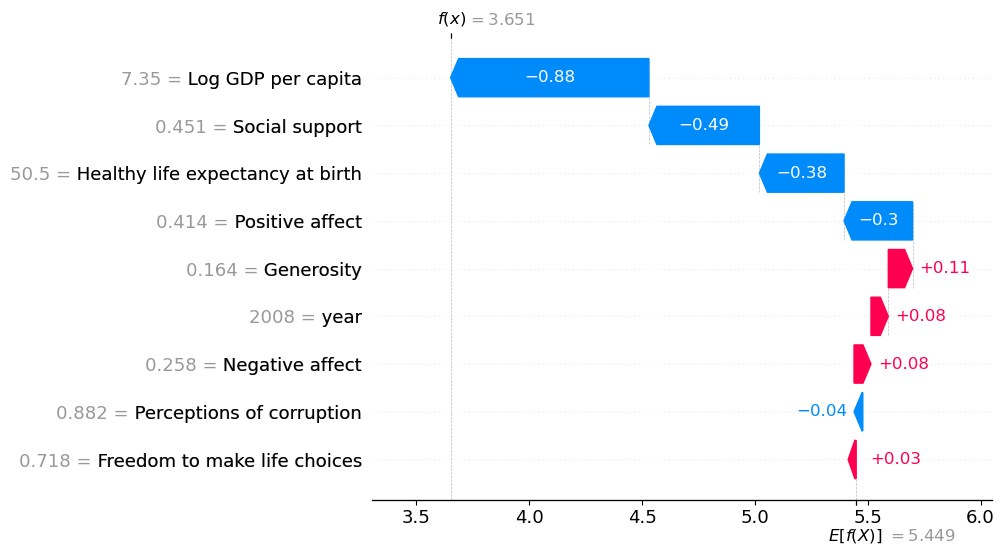

In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
import shap

model1 =lightgbm.LGBMRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model1)
shap_values = explainer(features_train)

shap.plots.waterfall(shap_values[0])


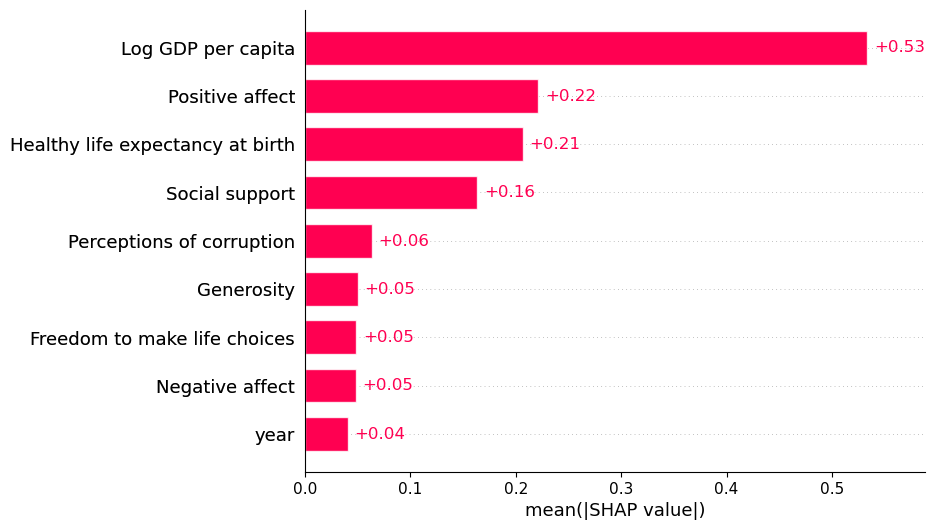

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
#features_test = pd.DataFrame(features_test)

# feature_names = features_test.columns.names
# Calculating SHAP values
model2 = CatBoostRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model2)
shap_values = explainer(features_test)

Learning rate set to 0.044626
0:	learn: 1.0948076	total: 2.57ms	remaining: 2.56s
1:	learn: 1.0603695	total: 3.88ms	remaining: 1.94s
2:	learn: 1.0276068	total: 5.17ms	remaining: 1.72s
3:	learn: 0.9969302	total: 6.45ms	remaining: 1.61s
4:	learn: 0.9677158	total: 7.61ms	remaining: 1.51s
5:	learn: 0.9407344	total: 8.79ms	remaining: 1.46s
6:	learn: 0.9142003	total: 10.3ms	remaining: 1.46s
7:	learn: 0.8899628	total: 11.5ms	remaining: 1.43s
8:	learn: 0.8662062	total: 13ms	remaining: 1.43s
9:	learn: 0.8423363	total: 14.3ms	remaining: 1.41s
10:	learn: 0.8198180	total: 15.8ms	remaining: 1.42s
11:	learn: 0.8005310	total: 17.6ms	remaining: 1.45s
12:	learn: 0.7803021	total: 19.1ms	remaining: 1.45s
13:	learn: 0.7611693	total: 20.4ms	remaining: 1.43s
14:	learn: 0.7430790	total: 21.7ms	remaining: 1.43s
15:	learn: 0.7261684	total: 24.1ms	remaining: 1.48s
16:	learn: 0.7108020	total: 25.8ms	remaining: 1.49s
17:	learn: 0.6956628	total: 27.4ms	remaining: 1.49s
18:	learn: 0.6811953	total: 29.5ms	remaining: 

In [ ]:
shap.initjs()

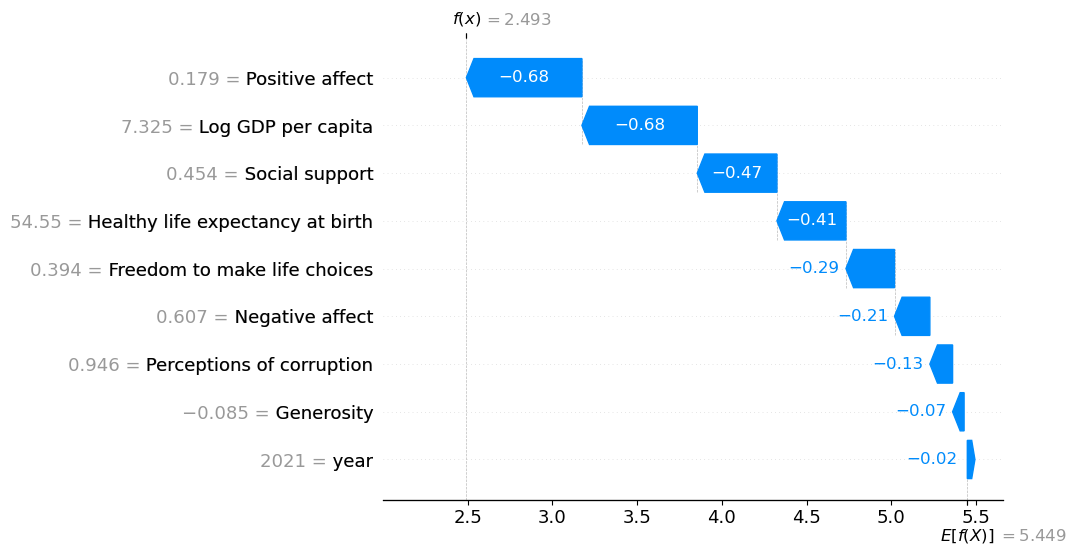

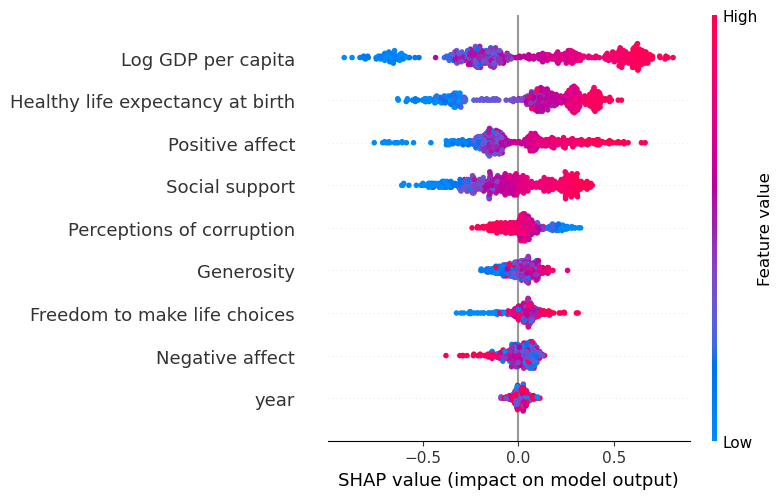

In [ ]:


shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, features_test)

#Summarize the SHAP values for a specific prediction
# feature_names = features_test.columns.names

# shap.force_plot(explainer.expected_value, shap_values[0].values, features_test.iloc[0], feature_names = feature_names)


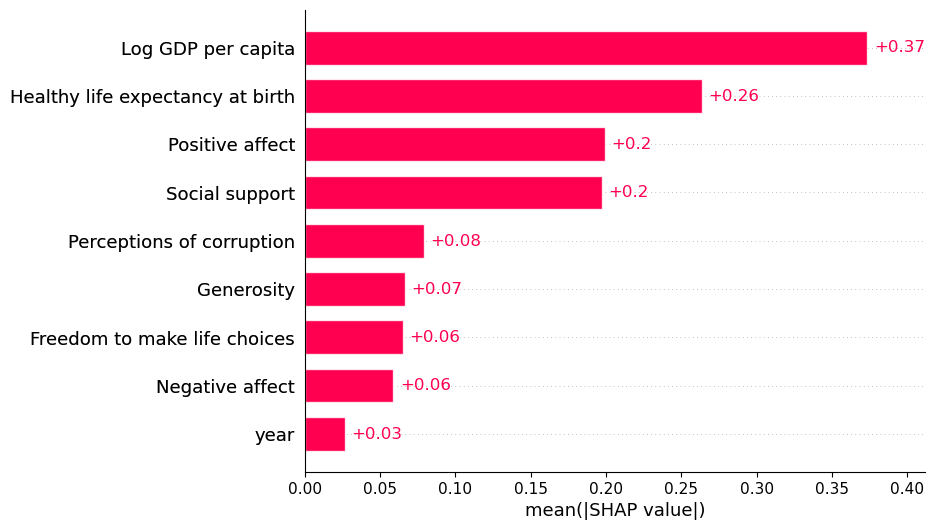

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# costa_row = training.index[training['Country name']=='Costa Rica'].tolist()[0]
# print(costa_row)

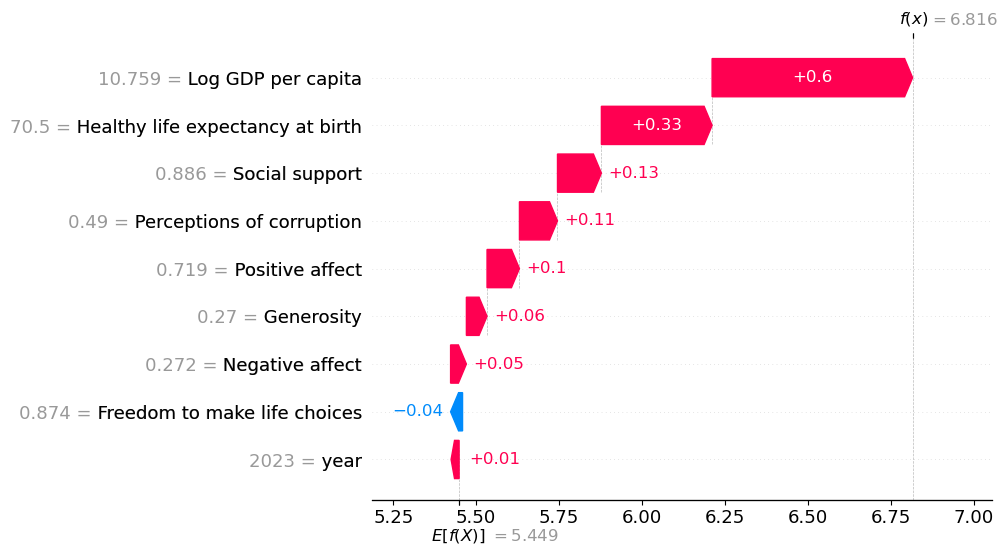

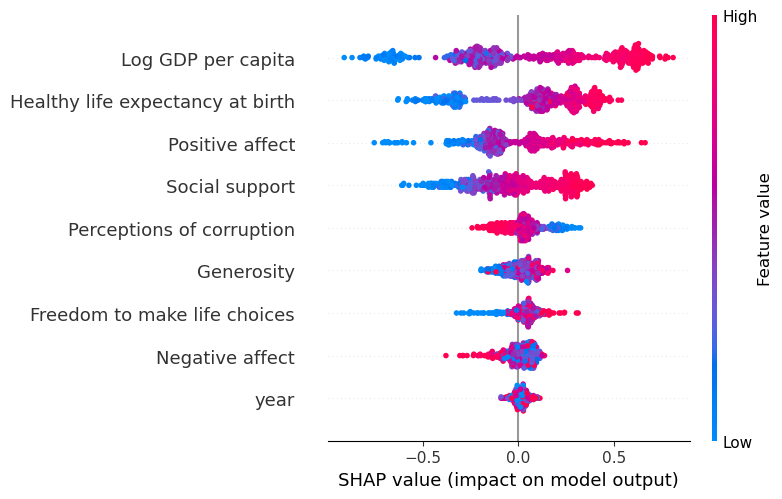

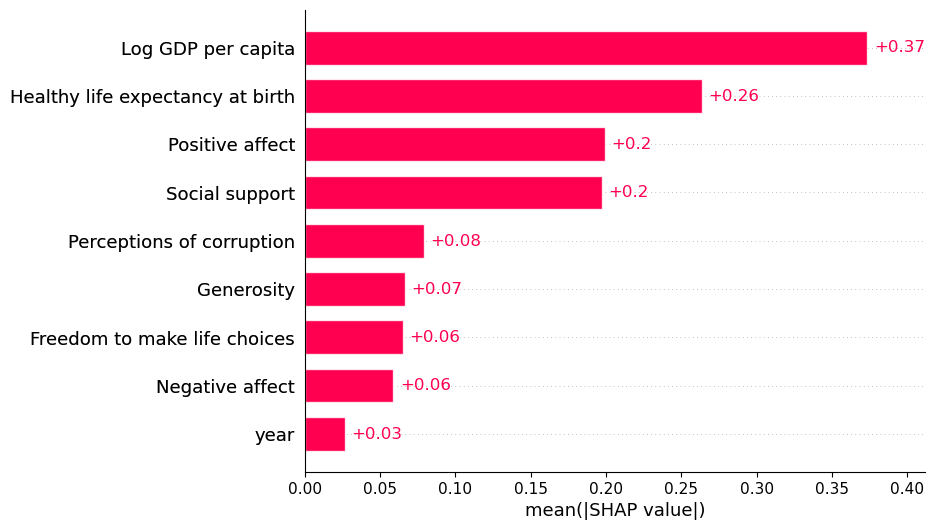

In [ ]:

shap.plots.waterfall(shap_values[473])
shap.summary_plot(shap_values, features_test)
shap.plots.bar(shap_values)

In [ ]:
print(test.iloc[473])

year                                2023.000
Life Ladder                            6.658
Log GDP per capita                    10.759
Social support                         0.886
Healthy life expectancy at birth      70.500
Freedom to make life choices           0.874
Generosity                             0.270
Perceptions of corruption              0.490
Positive affect                        0.719
Negative affect                        0.272
Name: 2224, dtype: float64


In [ ]:
test.tail(50)

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
2151,2020,4.862,10.257,0.857,68.575,0.510,-0.119,0.774,0.332,0.440
2152,2021,4.367,10.357,0.736,68.750,0.447,-0.039,0.810,0.297,0.471
2153,2022,5.093,10.404,0.830,68.925,0.470,-0.195,0.767,0.311,0.390
2154,2023,5.463,10.429,0.860,69.100,0.523,-0.159,0.748,0.344,0.349
2169,2020,4.641,7.714,0.800,58.675,0.687,0.140,0.878,0.705,0.425
2170,2021,4.225,7.717,0.793,59.150,0.711,0.081,0.835,0.699,0.359
2171,2022,4.425,7.733,0.781,59.625,0.720,0.135,0.836,0.708,0.439
2172,2023,4.467,7.759,0.827,60.100,0.848,0.067,0.912,0.726,0.376
2187,2020,5.270,9.426,0.885,64.425,0.784,0.121,0.946,0.629,0.285
2188,2021,5.311,9.469,0.879,64.550,0.770,0.166,0.922,0.575,0.250
